# RSA ANALYSIS OF VISUAL OBJECTS

In [1]:
import os.path as op
import numpy as np
from pandas import read_csv
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.manifold import MDS

import mne
from mne.io import read_raw_fif, concatenate_raws

In [ ]:
matplotlib.use('Qt5Agg')

### Define paths and load the data

In [2]:
# define path
sample_data_folder = '/Users/christinadelta/datasets/testing_vizdata'

# define stimulus trigger mapping
fname = op.join(sample_data_folder, 'visual_stimuli.csv')
conds = read_csv(fname)

### For now we will restrict the number of conditions to 24

In [3]:
max_trigger = 24
conds = conds[:max_trigger]
conds.values

array([[0, 'human bodypart', 1, 0, 1, 1],
       [1, 'human bodypart', 1, 0, 1, 1],
       [2, 'human bodypart', 1, 0, 1, 1],
       [3, 'human bodypart', 1, 0, 1, 1],
       [4, 'human bodypart', 1, 0, 1, 1],
       [5, 'human bodypart', 1, 0, 1, 1],
       [6, 'human bodypart', 1, 0, 1, 1],
       [7, 'human bodypart', 1, 0, 1, 1],
       [8, 'human bodypart', 1, 0, 1, 1],
       [9, 'human bodypart', 1, 0, 1, 1],
       [10, 'human bodypart', 1, 0, 1, 1],
       [11, 'human bodypart', 1, 0, 1, 1],
       [12, 'human face', 1, 1, 1, 1],
       [13, 'human face', 1, 1, 1, 1],
       [14, 'human face', 1, 1, 1, 1],
       [15, 'human face', 1, 1, 1, 1],
       [16, 'human face', 1, 1, 1, 1],
       [17, 'human face', 1, 1, 1, 1],
       [18, 'human face', 1, 1, 1, 1],
       [19, 'human face', 1, 1, 1, 1],
       [20, 'human face', 1, 1, 1, 1],
       [21, 'human face', 1, 1, 1, 1],
       [22, 'human face', 1, 1, 1, 1],
       [23, 'human face', 1, 1, 1, 1]], dtype=object)

In [4]:
conditions = []
for c in conds.values:
    cond_tags = list(c[:2])
    cond_tags += [('not-' if i == 0 else '') + conds.columns[k]
                  for k, i in enumerate(c[2:], 2)]
    conditions.append('/'.join(map(str, cond_tags)))

conditions

['0/human bodypart/human/not-face/animal/natural',
 '1/human bodypart/human/not-face/animal/natural',
 '2/human bodypart/human/not-face/animal/natural',
 '3/human bodypart/human/not-face/animal/natural',
 '4/human bodypart/human/not-face/animal/natural',
 '5/human bodypart/human/not-face/animal/natural',
 '6/human bodypart/human/not-face/animal/natural',
 '7/human bodypart/human/not-face/animal/natural',
 '8/human bodypart/human/not-face/animal/natural',
 '9/human bodypart/human/not-face/animal/natural',
 '10/human bodypart/human/not-face/animal/natural',
 '11/human bodypart/human/not-face/animal/natural',
 '12/human face/human/face/animal/natural',
 '13/human face/human/face/animal/natural',
 '14/human face/human/face/animal/natural',
 '15/human face/human/face/animal/natural',
 '16/human face/human/face/animal/natural',
 '17/human face/human/face/animal/natural',
 '18/human face/human/face/animal/natural',
 '19/human face/human/face/animal/natural',
 '20/human face/human/face/animal/

### Make the event_id dictionary

In [5]:
event_id = dict(zip(conditions, conds.trigger + 1))
event_id 

event_id['0/human bodypart/human/not-face/animal/natural']

1

### Load the MEG data

In [6]:
n_runs = 2  # 4 for full data (use less to speed up computations)
fname = op.join(sample_data_folder, 'sample_subject_%i_tsss_mc.fif')
raws = [read_raw_fif(fname % block, verbose='error')
        for block in range(n_runs)]  # ignore filename warnings

In [7]:
raws

[<Raw | sample_subject_0_tsss_mc.fif, 323 x 1592000 (1592.0 s), ~6.4 MB, data not loaded>,
 <Raw | sample_subject_1_tsss_mc.fif, 323 x 1592000 (1592.0 s), ~6.4 MB, data not loaded>]

In [8]:
raw = concatenate_raws(raws)

In [9]:
raw.info

<Info | 24 non-empty values
 acq_pars: ACQactiveGround 1 ACQch.BIO001.gain 2000 ACQch.BIO001.highpass ...
 bads: []
 ch_names: MEG0111, MEG0112, MEG0113, MEG0121, MEG0122, MEG0123, MEG0131, ...
 chs: 102 MAG, 204 GRAD, 6 MISC, 1 STIM, 1 SYST, 9 CHPI
 custom_ref_applied: False
 description: Vectorview system
 dev_head_t: MEG device -> head transform
 dig: 64 items (3 Cardinal, 5 HPI, 56 Extra)
 events: 1 item (list)
 experimenter: meg (meg)
 file_id: 4 items (dict)
 gantry_angle: 68.0
 highpass: 0.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 2 items (dict)
 line_freq: 60.0
 lowpass: 330.0 Hz
 meas_date: 2013-06-26 00:20:37 UTC
 meas_id: 4 items (dict)
 nchan: 323
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: rmc
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 7 items (dict)
>

In [10]:
events = mne.find_events(raw, min_duration=.002)

# keep only events for the 24 first conds 
events = events[events[:, 2] <= max_trigger]
events.shape

2730 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93 200 222 244]


(477, 3)

### Epoch data

In [11]:
picks = mne.pick_types(raw.info, meg=True)
epochs = mne.Epochs(raw, events=events, event_id=event_id, baseline=None,
                    picks=picks, tmin=-.1, tmax=.500, preload=True)

Not setting metadata
Not setting metadata
477 matching events found
No baseline correction applied
0 projection items activated
Loading data for 477 events and 601 original time points ...
0 bad epochs dropped


### Plot epochs 

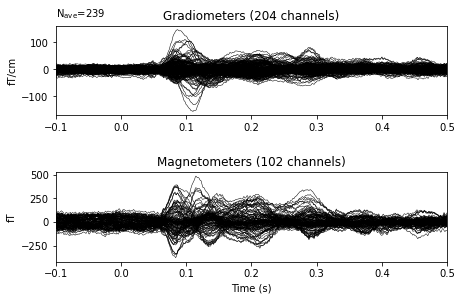

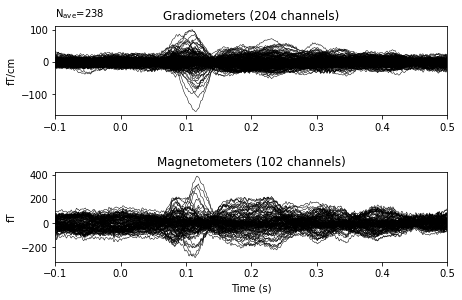

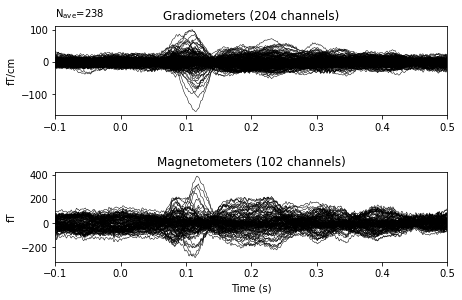

In [12]:
epochs['face'].average().plot()
epochs['not-face'].average().plot()

## Representational Similarity Analysis

confusion matrix also known as the Representational Dissimilarity Matrix (RDM) 

* the notebook uses multiclass classifier (Multinomial Logistic Regression) 
    * **Pairwise binary classification can also be used**
* Performance metric:ROC-AUC 
    * **Accuracy can also be used to assess performace of the classifier**
* RSA is performed on a time-window of the data
    * **RSA can be computed on each time instant separately**

In [14]:
# Classify using the average signal in the window 50ms to 300ms
# to focus the classifier on the time interval with best SNR.
clf = make_pipeline(StandardScaler(),
                    LogisticRegression(C=1, solver='liblinear',
                                       multi_class='auto'))

In [15]:
X = epochs.copy().crop(0.05, 0.3).get_data().mean(axis=2)

In [16]:
y = epochs.events[:, 2]
classes = set(y)

In [17]:
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
cv

StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

In [25]:
# Compute confusion matrix for each cross-validation fold
y_pred = np.zeros((len(y), len(classes)))

In [27]:
y_pred.shape

(477, 24)

In [30]:
for train, test in cv.split(X, y):
    # Fit
    clf.fit(X[train], y[train])
    # Probabilistic prediction (necessary for ROC-AUC scoring metric)
    y_pred[test] = clf.predict_proba(X[test])

### Compute confusion matrix using ROC-AUC

In [33]:
confusion = np.zeros((len(classes), len(classes)))
for ii, train_class in enumerate(classes):
    for jj in range(ii, len(classes)):
        confusion[ii, jj] = roc_auc_score(y == train_class, y_pred[:, jj])
        confusion[jj, ii] = confusion[ii, jj]

In [47]:
confusion.shape

(24, 24)

### Plot

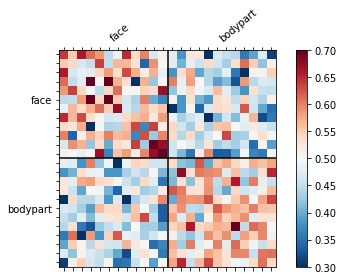

In [34]:
labels = [''] * 5 + ['face'] + [''] * 11 + ['bodypart'] + [''] * 6
fig, ax = plt.subplots(1)
im = ax.matshow(confusion, cmap='RdBu_r', clim=[0.3, 0.7])
ax.set_yticks(range(len(classes)))
ax.set_yticklabels(labels)
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(labels, rotation=40, ha='left')
ax.axhline(11.5, color='k')
ax.axvline(11.5, color='k')
plt.colorbar(im)
plt.tight_layout()
plt.show()

Confusion matrix related to mental representations have been historically summarized with dimensionality reduction using multi-dimensional scaling. See how the face samples cluster together.

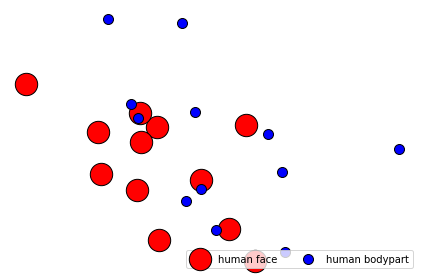

In [35]:
fig, ax = plt.subplots(1)
mds = MDS(2, random_state=0, dissimilarity='precomputed')
chance = 0.5
summary = mds.fit_transform(chance - confusion)
cmap = plt.get_cmap('rainbow')
colors = ['r', 'b']
names = list(conds['condition'].values)
for color, name in zip(colors, set(names)):
    sel = np.where([this_name == name for this_name in names])[0]
    size = 500 if name == 'human face' else 100
    ax.scatter(summary[sel, 0], summary[sel, 1], s=size,
               facecolors=color, label=name, edgecolors='k')
ax.axis('off')
ax.legend(loc='lower right', scatterpoints=1, ncol=2)
plt.tight_layout()
plt.show()